# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    

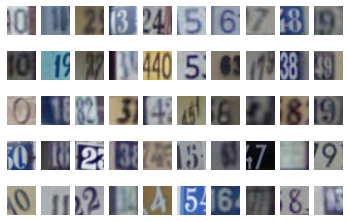

In [4]:
samples_per_class = 5
digits_count = 10
plot_index = 1
for example_index in range(samples_per_class):
    for class_index in range(digits_count):
        plt.subplot(samples_per_class, digits_count, plot_index)
        image = train_X[train_y == class_index][example_index]
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        plot_index += 1

In [5]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis=0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones

In [6]:
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)

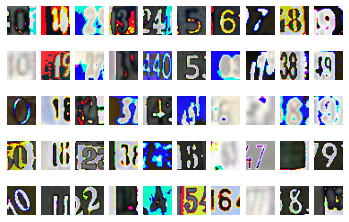

In [7]:
samples_per_class = 5
digits_count = 10
plot_index = 1
for example_index in range(samples_per_class):
    for class_index in range(digits_count):
        plt.subplot(samples_per_class, digits_count, plot_index)
        image = train_X[train_y == class_index][example_index][:-1].reshape(32, 32, 3) * 255.0
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        plot_index += 1

In [8]:
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val=1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [9]:
def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

Gradient check passed!


True

In [10]:
def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

Gradient check passed!


True

In [11]:
def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [12]:
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [13]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, np.array([1]))

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [14]:
pred = np.array([1, 0, 0], dtype=float)
gt = np.array([1])
loss, grad = linear_classifer.softmax_with_cross_entropy(pred, gt)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, gt), pred)

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [15]:
np.random.seed(42)
num_classes = 4

In [16]:
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(float)
target_index = np.random.randint(0, num_classes, size=batch_size).astype(int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

Gradient check passed!


True

In [17]:
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(float)
target_index = np.random.randint(0, num_classes, size=batch_size).astype(int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

Gradient check passed!


True

In [18]:
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [19]:
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(float)
target_index = np.ones(batch_size, dtype=int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [20]:
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [21]:
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

100%|██████████| 10/10 [00:01<00:00,  8.54it/s]


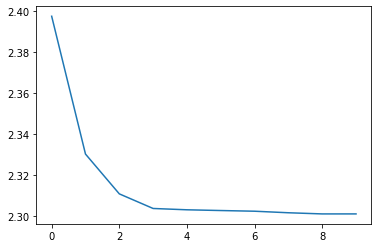

In [22]:
plt.plot(loss_history)

In [23]:
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

Accuracy:  0.127


In [24]:
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)

100%|██████████| 100/100 [00:12<00:00,  7.93it/s]


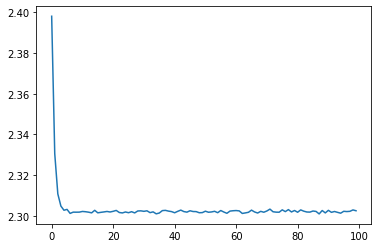

In [25]:
plt.plot(loss_history)

In [26]:
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy after training for 100 epochs:  0.127


### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [27]:
num_epochs = 200
batch_size = 300

In [28]:
best_val_accuracy = None
best_learning_rate = None
best_reg_strength = None
best_classifier = None

reg_strengths = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
learning_rates = [1e-1, 5e-2, 2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 5e-4, 2e-4, 1e-4]

for reg_strength in reg_strengths:
    for learning_rate in learning_rates:
        classifier = linear_classifer.LinearSoftmaxClassifier()
        classifier.fit(train_X, train_y, 
                       epochs=num_epochs, 
                       learning_rate=learning_rate, 
                       batch_size=batch_size, 
                       reg=reg_strength)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)

        if best_val_accuracy is None or best_val_accuracy < accuracy:
            best_val_accuracy = accuracy
            best_learning_rate = learning_rate
            best_reg_strength = reg_strength
            best_classifier = classifier
            
        print('R_S =', reg_strength, flush=True)
        print('L_R =', learning_rate, flush=True)
        print('ACC =', accuracy, flush=True)
        

print('*****************************', flush=True)
print('BEST R_S =', best_reg_strength, flush=True)
print('BEST L_R =', best_learning_rate, flush=True)
print('BEST ACC =', best_val_accuracy, flush=True)

100%|██████████| 200/200 [00:26<00:00,  7.46it/s]

R_S = 1
L_R = 0.1
ACC = 0.12



100%|██████████| 200/200 [00:23<00:00,  8.47it/s]

R_S = 1
L_R = 0.05
ACC = 0.159



100%|██████████| 200/200 [00:23<00:00,  8.64it/s]

R_S = 1
L_R = 0.02
ACC = 0.143



100%|██████████| 200/200 [00:23<00:00,  8.66it/s]

R_S = 1
L_R = 0.01
ACC = 0.17



100%|██████████| 200/200 [00:23<00:00,  8.65it/s]

R_S = 1
L_R = 0.005
ACC = 0.185



100%|██████████| 200/200 [00:22<00:00,  8.70it/s]

R_S = 1
L_R = 0.002
ACC = 0.17



100%|██████████| 200/200 [00:23<00:00,  8.62it/s]

R_S = 1
L_R = 0.001
ACC = 0.172



100%|██████████| 200/200 [00:23<00:00,  8.36it/s]

R_S = 1
L_R = 0.0005
ACC = 0.173



100%|██████████| 200/200 [00:23<00:00,  8.53it/s]

R_S = 1
L_R = 0.0002
ACC = 0.169



100%|██████████| 200/200 [00:23<00:00,  8.59it/s]

R_S = 1
L_R = 0.0001
ACC = 0.168



100%|██████████| 200/200 [00:22<00:00,  8.75it/s]

R_S = 0.1
L_R = 0.1
ACC = 0.208



100%|██████████| 200/200 [00:22<00:00,  8.73it/s]

R_S = 0.1
L_R = 0.05
ACC = 0.228



100%|██████████| 200/200 [00:23<00:00,  8.43it/s]

R_S = 0.1
L_R = 0.02
ACC = 0.234



100%|██████████| 200/200 [00:23<00:00,  8.63it/s]

R_S = 0.1
L_R = 0.01
ACC = 0.224



100%|██████████| 200/200 [00:23<00:00,  8.60it/s]

R_S = 0.1
L_R = 0.005
ACC = 0.227



100%|██████████| 200/200 [00:23<00:00,  8.53it/s]

R_S = 0.1
L_R = 0.002
ACC = 0.227



100%|██████████| 200/200 [00:23<00:00,  8.67it/s]

R_S = 0.1
L_R = 0.001
ACC = 0.223



100%|██████████| 200/200 [00:23<00:00,  8.68it/s]

R_S = 0.1
L_R = 0.0005
ACC = 0.214



100%|██████████| 200/200 [00:23<00:00,  8.69it/s]

R_S = 0.1
L_R = 0.0002
ACC = 0.191



100%|██████████| 200/200 [00:23<00:00,  8.52it/s]

R_S = 0.1
L_R = 0.0001
ACC = 0.175



100%|██████████| 200/200 [00:23<00:00,  8.46it/s]

R_S = 0.01
L_R = 0.1
ACC = 0.242



100%|██████████| 200/200 [00:23<00:00,  8.47it/s]

R_S = 0.01
L_R = 0.05
ACC = 0.238



100%|██████████| 200/200 [00:22<00:00,  8.77it/s]

R_S = 0.01
L_R = 0.02
ACC = 0.243



100%|██████████| 200/200 [00:23<00:00,  8.66it/s]

R_S = 0.01
L_R = 0.01
ACC = 0.244



100%|██████████| 200/200 [00:23<00:00,  8.61it/s]

R_S = 0.01
L_R = 0.005
ACC = 0.231



100%|██████████| 200/200 [00:23<00:00,  8.59it/s]

R_S = 0.01
L_R = 0.002
ACC = 0.228



100%|██████████| 200/200 [00:23<00:00,  8.63it/s]

R_S = 0.01
L_R = 0.001
ACC = 0.225



100%|██████████| 200/200 [00:23<00:00,  8.56it/s]

R_S = 0.01
L_R = 0.0005
ACC = 0.214



100%|██████████| 200/200 [00:23<00:00,  8.62it/s]

R_S = 0.01
L_R = 0.0002
ACC = 0.191



100%|██████████| 200/200 [00:23<00:00,  8.49it/s]

R_S = 0.01
L_R = 0.0001
ACC = 0.177



100%|██████████| 200/200 [00:23<00:00,  8.55it/s]

R_S = 0.001
L_R = 0.1
ACC = 0.238



100%|██████████| 200/200 [00:23<00:00,  8.64it/s]

R_S = 0.001
L_R = 0.05
ACC = 0.245



100%|██████████| 200/200 [00:23<00:00,  8.50it/s]

R_S = 0.001
L_R = 0.02
ACC = 0.245



100%|██████████| 200/200 [00:23<00:00,  8.51it/s]

R_S = 0.001
L_R = 0.01
ACC = 0.238



100%|██████████| 200/200 [00:23<00:00,  8.63it/s]

R_S = 0.001
L_R = 0.005
ACC = 0.242



100%|██████████| 200/200 [00:22<00:00,  8.73it/s]

R_S = 0.001
L_R = 0.002
ACC = 0.226



100%|██████████| 200/200 [00:23<00:00,  8.45it/s]

R_S = 0.001
L_R = 0.001
ACC = 0.228



100%|██████████| 200/200 [00:23<00:00,  8.67it/s]

R_S = 0.001
L_R = 0.0005
ACC = 0.214



100%|██████████| 200/200 [00:23<00:00,  8.47it/s]

R_S = 0.001
L_R = 0.0002
ACC = 0.201



100%|██████████| 200/200 [00:23<00:00,  8.61it/s]

R_S = 0.001
L_R = 0.0001
ACC = 0.172



100%|██████████| 200/200 [00:22<00:00,  8.70it/s]

R_S = 0.0001
L_R = 0.1
ACC = 0.241



100%|██████████| 200/200 [00:23<00:00,  8.53it/s]

R_S = 0.0001
L_R = 0.05
ACC = 0.252



100%|██████████| 200/200 [00:23<00:00,  8.56it/s]

R_S = 0.0001
L_R = 0.02
ACC = 0.252



100%|██████████| 200/200 [00:23<00:00,  8.56it/s]

R_S = 0.0001
L_R = 0.01
ACC = 0.242



100%|██████████| 200/200 [00:23<00:00,  8.66it/s]

R_S = 0.0001
L_R = 0.005
ACC = 0.241



100%|██████████| 200/200 [00:23<00:00,  8.60it/s]

R_S = 0.0001
L_R = 0.002
ACC = 0.227



100%|██████████| 200/200 [00:23<00:00,  8.65it/s]

R_S = 0.0001
L_R = 0.001
ACC = 0.227



100%|██████████| 200/200 [00:23<00:00,  8.60it/s]

R_S = 0.0001
L_R = 0.0005
ACC = 0.214



100%|██████████| 200/200 [00:23<00:00,  8.53it/s]

R_S = 0.0001
L_R = 0.0002
ACC = 0.193



100%|██████████| 200/200 [00:23<00:00,  8.57it/s]

R_S = 0.0001
L_R = 0.0001
ACC = 0.173



100%|██████████| 200/200 [00:23<00:00,  8.65it/s]

R_S = 1e-05
L_R = 0.1
ACC = 0.238



100%|██████████| 200/200 [00:23<00:00,  8.58it/s]

R_S = 1e-05
L_R = 0.05
ACC = 0.248



100%|██████████| 200/200 [00:23<00:00,  8.63it/s]

R_S = 1e-05
L_R = 0.02
ACC = 0.242



100%|██████████| 200/200 [00:23<00:00,  8.55it/s]

R_S = 1e-05
L_R = 0.01
ACC = 0.243



100%|██████████| 200/200 [00:23<00:00,  8.63it/s]

R_S = 1e-05
L_R = 0.005
ACC = 0.24



100%|██████████| 200/200 [00:23<00:00,  8.63it/s]

R_S = 1e-05
L_R = 0.002
ACC = 0.227



100%|██████████| 200/200 [00:23<00:00,  8.60it/s]

R_S = 1e-05
L_R = 0.001
ACC = 0.229



100%|██████████| 200/200 [00:23<00:00,  8.53it/s]

R_S = 1e-05
L_R = 0.0005
ACC = 0.215



100%|██████████| 200/200 [00:23<00:00,  8.55it/s]

R_S = 1e-05
L_R = 0.0002
ACC = 0.197



100%|██████████| 200/200 [00:23<00:00,  8.61it/s]

R_S = 1e-05
L_R = 0.0001
ACC = 0.174



100%|██████████| 200/200 [00:23<00:00,  8.44it/s]

R_S = 1e-06
L_R = 0.1
ACC = 0.247



100%|██████████| 200/200 [00:23<00:00,  8.60it/s]

R_S = 1e-06
L_R = 0.05
ACC = 0.247



100%|██████████| 200/200 [00:23<00:00,  8.64it/s]

R_S = 1e-06
L_R = 0.02
ACC = 0.248



100%|██████████| 200/200 [00:23<00:00,  8.64it/s]

R_S = 1e-06
L_R = 0.01
ACC = 0.245



100%|██████████| 200/200 [00:23<00:00,  8.61it/s]

R_S = 1e-06
L_R = 0.005
ACC = 0.243



100%|██████████| 200/200 [00:23<00:00,  8.53it/s]

R_S = 1e-06
L_R = 0.002
ACC = 0.228



100%|██████████| 200/200 [00:23<00:00,  8.61it/s]

R_S = 1e-06
L_R = 0.001
ACC = 0.228



100%|██████████| 200/200 [00:24<00:00,  8.27it/s]

R_S = 1e-06
L_R = 0.0005
ACC = 0.218



100%|██████████| 200/200 [00:27<00:00,  7.15it/s]

R_S = 1e-06
L_R = 0.0002
ACC = 0.199



100%|██████████| 200/200 [00:28<00:00,  7.14it/s]

R_S = 1e-06
L_R = 0.0001
ACC = 0.176



100%|██████████| 200/200 [00:26<00:00,  7.56it/s]

R_S = 1e-07
L_R = 0.1
ACC = 0.249



100%|██████████| 200/200 [00:23<00:00,  8.52it/s]

R_S = 1e-07
L_R = 0.05
ACC = 0.25



100%|██████████| 200/200 [00:34<00:00,  5.83it/s]

R_S = 1e-07
L_R = 0.02
ACC = 0.246



100%|██████████| 200/200 [00:23<00:00,  8.56it/s]

R_S = 1e-07
L_R = 0.01
ACC = 0.246



100%|██████████| 200/200 [00:22<00:00,  8.71it/s]

R_S = 1e-07
L_R = 0.005
ACC = 0.243



100%|██████████| 200/200 [00:23<00:00,  8.68it/s]

R_S = 1e-07
L_R = 0.002
ACC = 0.228



100%|██████████| 200/200 [00:22<00:00,  8.71it/s]

R_S = 1e-07
L_R = 0.001
ACC = 0.227



100%|██████████| 200/200 [00:23<00:00,  8.59it/s]

R_S = 1e-07
L_R = 0.0005
ACC = 0.214



100%|██████████| 200/200 [00:23<00:00,  8.57it/s]

R_S = 1e-07
L_R = 0.0002
ACC = 0.191



100%|██████████| 200/200 [00:22<00:00,  8.75it/s]

R_S = 1e-07
L_R = 0.0001
ACC = 0.17
*****************************
BEST R_S = 0.0001
BEST L_R = 0.05
BEST ACC = 0.252


# Какой же точности мы добились на тестовых данных?

In [30]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.215000
